## This notebook is separated from dog_app for addressing only step1.

## Step 0: Import Datasets

### Import Dog Dataset

In the code cell below, we import a dataset of dog images.  We populate a few variables through the use of the `load_files` function from the scikit-learn library:
- `train_files`, `valid_files`, `test_files` - numpy arrays containing file paths to images
- `train_targets`, `valid_targets`, `test_targets` - numpy arrays containing onehot-encoded classification labels 
- `dog_names` - list of string-valued dog breed names for translating labels

In [35]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob

# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('dogImages/train')
valid_files, valid_targets = load_dataset('dogImages/valid')
test_files, test_targets = load_dataset('dogImages/test')

# load list of dog names
dog_names = [item[20:-1] for item in sorted(glob("dogImages/train/*/"))]

# print statistics about the dataset
print('There are %d total dog categories.' % len(dog_names))
print('There are %s total dog images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training dog images.' % len(train_files))
print('There are %d validation dog images.' % len(valid_files))
print('There are %d test dog images.'% len(test_files))

There are 133 total dog categories.
There are 8351 total dog images.

There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.


### Import Human Dataset

In the code cell below, we import a dataset of human images, where the file paths are stored in the numpy array `human_files`.

In [36]:
import random
random.seed(8675309)

# load filenames in shuffled human dataset
human_files = np.array(glob("lfw/*/*"))
random.shuffle(human_files)

# print statistics about the dataset
print('There are %d total human images.' % len(human_files))

There are 13233 total human images.


---
<a id='step1'></a>
## Step 1: Detect Humans

We use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.

In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 1


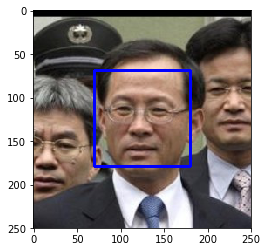

In [37]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[3])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [38]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### (IMPLEMENTATION) Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

__Answer:__ 

In [39]:
human_files_short = human_files[:100]
dog_files_short = train_files[:100]
# Do NOT modify the code above this line.

## TODO: Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.
human_results = list()
for img in human_files_short:
    human_results.append(face_detector(img))
dog_results = list()
for img in dog_files_short:
    dog_results.append(face_detector(img))

human_detected_num = human_results.count(True)
human_accuracy = (human_detected_num / len(human_files_short)) * 100.0
print(f"human accuracy:{human_accuracy}")
dog_detected_num = dog_results.count(True)
dog_accuracy = (dog_detected_num / len(dog_files_short)) * 100.0
print(f"dog accuracy:{dog_accuracy}")

human accuracy:99.0
dog accuracy:11.0


__Question 2:__ This algorithmic choice necessitates that we communicate to the user that we accept human images only when they provide a clear view of a face (otherwise, we risk having unneccessarily frustrated users!). In your opinion, is this a reasonable expectation to pose on the user? If not, can you think of a way to detect humans in images that does not necessitate an image with a clearly presented face?

__Answer:__

We suggest the face detector from OpenCV as a potential way to detect human images in your algorithm, but you are free to explore other approaches, especially approaches that make use of deep learning :).  Please use the code cell below to design and test your own face detection algorithm.  If you decide to pursue this _optional_ task, report performance on each of the datasets.

In [40]:
## (Optional) TODO: Report the performance of another  
## face detection algorithm on the LFW dataset
### Feel free to use as many code cells as needed.

### about face detector

For detecting human, we do not necessarily need to detect faces. Because human bodies and gestures should be also recognized as human.
Furthermore, face_detector's dog excluding accuracy is bad(11% wrong). So there seems to be improvement points at how to exclude non-human.

### my approach
use transfer learning

### create human training data set

In [41]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob

# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    files = np.array(data['filenames'])
    targets = np_utils.to_categorical(np.array(data['target']), 133)
    return files, targets


from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(256, 256))
    # convert PIL.Image.Image type to 3D tensor with shape (256, 256, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 256, 256, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

In [42]:
import random
random.seed(8675309)

# load filenames in shuffled human dataset
human_files = np.array(glob("lfw/*/*"))
random.shuffle(human_files)

# print statistics about the dataset
print('There are %d total human images.' % len(human_files))

There are 13233 total human images.


In [43]:
import os
import shutil
import numpy as np
from glob import glob

TRAINING_DIR_HUMAN = "human/train/human"
VALID_DIR_HUMAN = "human/valid/human"
TEST_DIR_HUMAN = "human/test/human"
TRAINING_DIR_NOHUMAN = "human/train/nohuman"
VALID_DIR_NOHUMAN = "human/valid/nohuman"
TEST_DIR_NOHUMAN = "human/test/nohuman"

dirs = [
    TRAINING_DIR_HUMAN,
    VALID_DIR_HUMAN,
    TEST_DIR_HUMAN,
    TRAINING_DIR_NOHUMAN,
    VALID_DIR_NOHUMAN,
    TEST_DIR_NOHUMAN,
       ]
#  clean dataset
for imagedir in dirs: 
    try:
        shutil.rmtree(imagedir)
    except:
        pass
    try:
        os.makedirs(imagedir)
    except:
        pass


# copy human images to human dataset dir
human_training_files = human_files[:int(len(human_files) * 0.6)]
human_valid_files = human_files[int(len(human_files) * 0.6):int(len(human_files) * 0.8)]
human_test_files = human_files[int(len(human_files) * 0.8):]
for filepath in human_training_files:
    filename = os.path.basename(filepath)
    shutil.copyfile(filepath, TRAINING_DIR_HUMAN + "/" + filename)

for filepath in human_valid_files:
    filename = os.path.basename(filepath)
    shutil.copyfile(filepath, VALID_DIR_HUMAN + "/" + filename)

for filepath in human_test_files:
    filename = os.path.basename(filepath)
    shutil.copyfile(filepath, TEST_DIR_HUMAN + "/" + filename)

# copy dog images to nohuman dataset dir
# load train, test, and validation datasets
dog_training_files, _ = load_dataset('dogImages/train')
dog_valid_files, _ = load_dataset('dogImages/valid')
dog_test_files, _ = load_dataset('dogImages/test')
for filepath in dog_training_files:
    filename = os.path.basename(filepath)
    shutil.copyfile(filepath, TRAINING_DIR_NOHUMAN + "/" + filename)

for filepath in dog_valid_files:
    filename = os.path.basename(filepath)
    shutil.copyfile(filepath, VALID_DIR_NOHUMAN + "/" + filename)

for filepath in dog_test_files:
    filename = os.path.basename(filepath)
    shutil.copyfile(filepath, TEST_DIR_NOHUMAN + "/" + filename)

training_data_num = len(np.array(glob(f"{TRAINING_DIR_HUMAN}/*"))) + len(np.array(glob(f"{TRAINING_DIR_NOHUMAN}/*")))
validation_data_num = len(np.array(glob(f"{VALID_DIR_HUMAN}/*"))) + len(np.array(glob(f"{VALID_DIR_NOHUMAN}/*")))
print('There are %d training human images.' % len(np.array(glob(f"{TRAINING_DIR_HUMAN}/*"))))
print('There are %d validation human images.' % len(np.array(glob(f"{VALID_DIR_HUMAN}/*"))))
print('There are %d test human images.' % len(np.array(glob(f"{TEST_DIR_HUMAN}/*"))))
print('There are %d training dog images.' % len(np.array(glob(f"{TRAINING_DIR_NOHUMAN}/*"))))
print('There are %d validation dog images.' % len(np.array(glob(f"{VALID_DIR_NOHUMAN}/*"))))
print('There are %d test dog images.'% len(np.array(glob(f"{TEST_DIR_NOHUMAN}/*"))))

There are 7939 training human images.
There are 2647 validation human images.
There are 2647 test human images.
There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.


### use bottle neck feature

In [44]:
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential, Model 
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D, BatchNormalization, MaxPooling2D
from keras import backend as k 
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping

# https://github.com/fchollet/keras/issues/5475
# https://stackoverflow.com/questions/12984426/python-pil-ioerror-image-file-truncated-with-big-images
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [45]:
img_width, img_height = 256, 256
train_data_dir = "human/train"
validation_data_dir = "human/valid"
batch_size = 50
epochs = 5
nb_train_samples = training_data_num // batch_size
nb_validation_samples = validation_data_num // batch_size
print(f"nb_train_samples={nb_train_samples} nb_validation_samples={nb_validation_samples}")


nb_train_samples=292 nb_validation_samples=69


In [46]:
# https://medium.com/towards-data-science/transfer-learning-using-keras-d804b2e04ef8
model = applications.VGG19(weights = "imagenet", include_top=False, input_shape = (img_width, img_height, 3))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0         
__________

In [47]:
# Freeze the layers which you don't want to train. Here I am freezing the first 5 layers.
for layer in model.layers:
    layer.trainable = False


In [48]:
#Adding custom Layers 
x = model.output
x = Flatten()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation="relu")(x)
predictions = Dense(2, activation="softmax")(x)


In [49]:
# creating the final model 
model_final = Model(inputs = model.input, outputs = predictions)

# compile the model 
model_final.compile(loss = "categorical_crossentropy", optimizer = optimizers.SGD(lr=0.0001, momentum=0.9), metrics=["accuracy"])


In [50]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
# Save the model according to the conditions  
early = EarlyStopping(monitor='val_loss', patience=0, verbose=1, mode='auto')
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.human.hdf5', 
                               verbose=1, save_best_only=True)


In [51]:
# Initiate the train and test generators with data Augumentation 
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    horizontal_flip = True,
    fill_mode = "nearest",
    zoom_range = 0.3,
    width_shift_range = 0.3,
    height_shift_range=0.3,
    rotation_range=30)

test_datagen = ImageDataGenerator(
    rescale = 1./255,
    horizontal_flip = True,
    fill_mode = "nearest",
    zoom_range = 0.3,
    width_shift_range = 0.3,
    height_shift_range=0.3,
    rotation_range=30)


In [52]:
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size = (img_height, img_width),
    batch_size = batch_size, 
    class_mode = "categorical")

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size = (img_height, img_width),
    class_mode = "categorical")

Found 14619 images belonging to 2 classes.
Found 3482 images belonging to 2 classes.


In [53]:
# Train the model 
model_final.fit_generator(
    train_generator,
    steps_per_epoch = nb_train_samples,
    epochs = epochs,
    validation_data = validation_generator,
    validation_steps = nb_validation_samples,
    callbacks = [checkpointer, early],
    verbose = 1)


Epoch 1/5
292/292 [==============================] - 285s - loss: 0.4042 - acc: 0.8206 - val_loss: 0.1741 - val_acc: 0.9579
Epoch 2/5
292/292 [==============================] - 289s - loss: 0.1993 - acc: 0.9319 - val_loss: 0.0992 - val_acc: 0.9728
Epoch 3/5
292/292 [==============================] - 292s - loss: 0.1476 - acc: 0.9500 - val_loss: 0.0831 - val_acc: 0.9746
Epoch 4/5
292/292 [==============================] - 297s - loss: 0.1244 - acc: 0.9571 - val_loss: 0.0665 - val_acc: 0.9809
Epoch 5/5
292/292 [==============================] - 296s - loss: 0.1029 - acc: 0.9663 - val_loss: 0.0629 - val_acc: 0.9823


In [54]:
from keras.applications.resnet50 import preprocess_input, decode_predictions

def predict_labels(img_path):
    # returns prediction vector for image located at img_path
    img = preprocess_input(path_to_tensor(img_path))
    return np.argmax(model_final.predict(img))

In [55]:
def human_detector(img_path):
    prediction = predict_labels(img_path)
    return prediction == 0

In [56]:
### on the images in human_files_short and dog_files_short.
# load filenames in shuffled human dataset
test_human_files = np.array(glob("human/test/human/*"))
human_files_short = test_human_files[:500]
dog_files_short = dog_test_files[:500]

# check all images in *_files_short
human_results = list()
for img in human_files_short:
    human_results.append(human_detector(img))
dog_results = list()
for img in dog_files_short:
    dog_results.append(human_detector(img))

# count up how many results are correct
human_detected_num = human_results.count(True)
human_accuracy = (human_detected_num / len(human_files_short)) * 100.0
print(f"human accuracy:{human_accuracy}")
dog_detected_num = dog_results.count(True)
dog_accuracy = (dog_detected_num / len(dog_files_short)) * 100.0
print(f"dog accuracy:{dog_accuracy}")

human accuracy:99.4
dog accuracy:0.0


### abount the result
The result was better than face_detector. especially F/P rate.